Mounted at /content/drive
Using device: cuda
✅ GPU is available. Training will be much faster.
Found 24 classes: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '3', '4', '5', '6', '7', '8', '9']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model output layer: Linear(in_features=512, out_features=24, bias=True)
Epoch 1/15 — Train Loss: 2.9497 — Val Acc: 17.92%
Epoch 2/15 — Train Loss: 2.5678 — Val Acc: 25.03%
Epoch 3/15 — Train Loss: 2.2932 — Val Acc: 30.49%
Epoch 4/15 — Train Loss: 2.0744 — Val Acc: 34.49%
Epoch 5/15 — Train Loss: 1.9172 — Val Acc: 41.31%
Epoch 6/15 — Train Loss: 1.7629 — Val Acc: 50.55%
Epoch 7/15 — Train Loss: 1.5733 — Val Acc: 58.16%
Epoch 8/15 — Train Loss: 1.3760 — Val Acc: 63.76%
Epoch 9/15 — Train Loss: 1.1917 — Val Acc: 68.76%
Epoch 10/15 — Train Loss: 1.0508 — Val Acc: 72.26%
Epoch 11/15 — Train Loss: 0.9259 — Val Acc: 75.01%
Epoch 12/15 — Train Loss: 0.8279 — Val Acc: 78.54%
Epoch 13/15 — Train Loss: 0.7382 — Val Acc: 80.72%
Epoch 14/15 — Train Loss: 0.6714 — Val Acc: 82.43%
Epoch 15/15 — Train Loss: 0.6150 — Val Acc: 83.43%


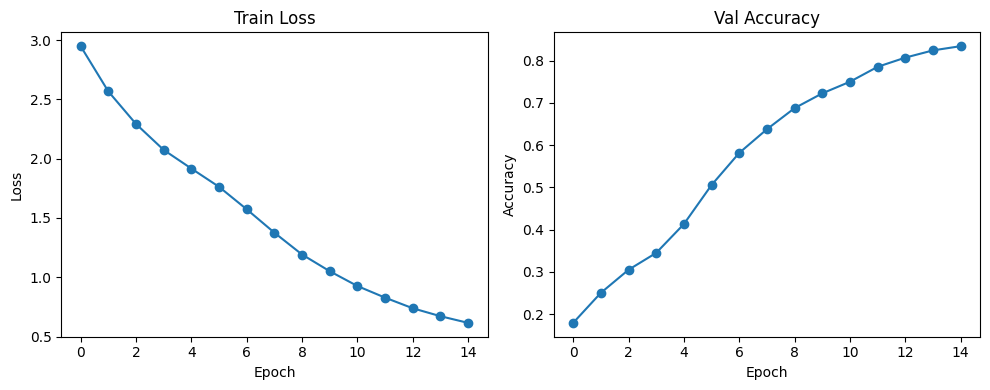


Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       122
           1       0.85      0.85      0.85       122
           2       0.94      0.87      0.90       122
           3       0.84      0.87      0.85       121
           4       0.91      0.86      0.89       122
           5       0.90      0.78      0.84       121
           6       0.89      0.90      0.90       121
           7       0.82      0.90      0.86       119
           8       0.83      0.91      0.87       122
           9       0.85      0.91      0.88       125
          10       0.88      0.88      0.88       120
          11       0.82      0.78      0.79       120
          12       0.88      0.85      0.86       119
          13       0.87      0.97      0.91       127
          14       0.84      0.93      0.88       121
          15       0.79      0.72      0.75        97
          16       0.79      0.38      0.51        29
  

In [1]:
# 1) Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2) Imports
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# 3) Device: dùng GPU nếu có
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("✅ GPU is available. Training will be much faster.")
else:
    print("⚠️ GPU not available. Using CPU — training may be slow.")

# 4) Paths & config
TRAIN_DIR   = "/content/drive/MyDrive/train_data"
TEST_DIR    = "/content/drive/MyDrive/test_data"
MODEL_PATH  = "/content/drive/MyDrive/best_model_gpu.pt"
IMG_SIZE    = 224
BATCH_SIZE  = 32
EPOCHS      = 15
valid_ext   = (".tif", ".tiff", ".png", ".jpg", ".jpeg")

# 5) Transforms
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 6) Load datasets
train_dataset = datasets.ImageFolder(
    TRAIN_DIR,
    transform=train_transform,
    is_valid_file=lambda x: x.lower().endswith(valid_ext)
)
test_dataset = datasets.ImageFolder(
    TEST_DIR,
    transform=test_transform,
    is_valid_file=lambda x: x.lower().endswith(valid_ext)
)

classes     = train_dataset.classes
num_classes = len(classes)
print(f"Found {num_classes} classes:", classes)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

# 7) Build model (ResNet18, grayscale)
resnet       = models.resnet18(pretrained=False)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet.fc    = nn.Linear(resnet.fc.in_features, num_classes)
model        = resnet.to(device)
print("Model output layer:", model.fc)

# 8) Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# 9) Training loop
train_losses, val_accuracies, best_acc = [], [], 0.0

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs      = model(imgs)
        loss         = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs    = imgs.to(device)
            outputs = model(imgs)
            preds   = outputs.argmax(dim=1).cpu().tolist()
            all_preds.extend(preds)
            all_labels.extend(labels.tolist())

    acc = accuracy_score(all_labels, all_preds)
    train_losses.append(running_loss / len(train_loader))
    val_accuracies.append(acc)

    # Save best
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), MODEL_PATH)

    print(f"Epoch {epoch}/{EPOCHS} — "
          f"Train Loss: {running_loss/len(train_loader):.4f} — "
          f"Val Acc: {acc*100:.2f}%")

# 10) Plot curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.title("Train Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(val_accuracies, marker='o')
plt.title("Val Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# 11) Classification report
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs    = imgs.to(device)
        outputs = model(imgs)
        preds   = outputs.argmax(dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(labels.tolist())

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, zero_division=0))
